In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, ".")

import asyncio
from src.main import run_round
from src.file_util import load_data, save_data, safe_load_yaml

Make sure to run `pip install -r requirements.txt` first (sorry if I missed any requirements there)

<Task pending name='Task-5' coro=<run_round() running at /Users/justin/github/mascot-bracket-constructor/./src/main.py:86>>

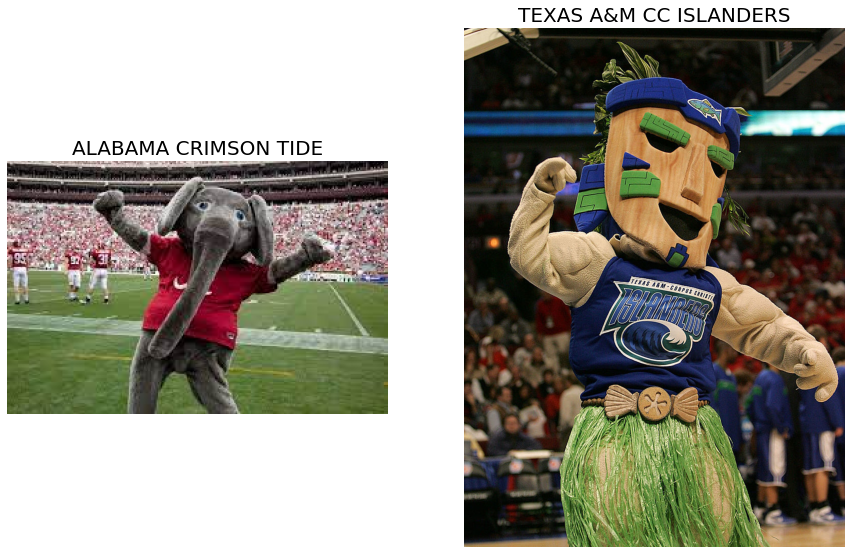

ToggleButtons(options=('ALABAMA', 'TEXAS A&M CC', 'RANDOM'), value='ALABAMA')

Button(description='Submit', icon='check', style=ButtonStyle())

In [6]:
# enter round 1 through 6
asyncio.create_task(run_round(1))

Either enter your picks at the same time as you see them here or load in a round's data through the below code: 

In [3]:
df2 = load_data(region="east", rnd=1)

df2.head(16)

,team_name,seed,region,round
effective_seed,,,,
1,purdue,1,east,1
2,marquette,2,east,1
3,kansas_state,3,east,1
4,tennessee,4,east,1
5,duke,5,east,1
6,kentucky,6,east,1
7,michigan_state,7,east,1
8,memphis,8,east,1
9,florida_atlantic,9,east,1
